<a href="https://colab.research.google.com/github/kevin09jung/scratch/blob/main/c_13_DNN_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%87%E1%85%AE%E1%86%AB%E1%84%85%E1%85%B2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작 분류
- 핸드폰 센서 데이터 분류
- 선형 모델, 랜덤포레스트, MLP, CNN, RNN 비교
- colab에서 실행해야 함 (keras 등 설치 필요)
 - 런타임 유형변경 - GPU로

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

In [ ]:
!curl https://raw.githubusercontent.com/StillWork/data/master/smartphone.zip\
    -o smartphone.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.4M  100 10.4M    0     0   109M      0 --:--:-- --:--:-- --:--:--  109M


In [ ]:
!unzip -o smartphone.zip

Archive:  smartphone.zip
  inflating: smartphone.txt          


In [ ]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [ ]:
!head -5 smartphone.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [ ]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis',
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone.txt', header=None, names=column_names)

In [ ]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086475 entries, 0 to 1086474
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1086475 non-null  int64  
 1   activity   1086475 non-null  object 
 2   timestamp  1086475 non-null  int64  
 3   x-axis     1086475 non-null  float64
 4   y-axis     1086475 non-null  float64
 5   z-axis     1086475 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 49.7+ MB


In [ ]:
# z-컬럼의 ';'를 삭제하고 문자열 타입을 숫자 타입으로 변경한다
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(np.float)

<ipython-input-10-afab5070d973>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['z-axis'] = df['z-axis'].apply(np.float)


In [ ]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


In [ ]:
(df['timestamp'] == 0).sum()

12845

In [ ]:
# 시각이 0이거나 음수인 샘플은 제외 (양수인 값만 사용)
df = df[df['timestamp'] > 0]
df.shape

(1073630, 6)

In [ ]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

# for activity in np.unique(df['activity']):
#     subset = df[df['activity'] == activity][:200]
#     plot_activity(activity, subset)

In [ ]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

# 일정 기간동안 (윈도우)의 행동이 유지되는 것을 파악
- 현재 샘플링 시간은 50ms임
- 윈도우 크기를 100으로 잡으면 5초 동안 동일한 행동을 유지하는 경우만 취하게 됨
- stat 모듈이 제공하는 mode() 함수를 사용하여 최빈값을 구하고 이것이 100 인 경우의 데이터만 사용함 (동일한 행동을 5초간 유지하였는지를 파악함)

## 스케일링

In [ ]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

## 훈련 데이터 검증 데이터 나누기
- 사용자를 기준으로 나누는 경우

In [ ]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]
# 랜덤하게 사용자를 선택하려면 choice() 사용

In [ ]:
user_list = list(df['user-id'].unique())
train_list = np.random.choice(user_list, 28, replace=False)
list(train_list)

[5,
 19,
 20,
 16,
 2,
 29,
 30,
 15,
 6,
 17,
 34,
 27,
 14,
 18,
 32,
 4,
 13,
 35,
 36,
 8,
 11,
 26,
 24,
 3,
 22,
 21,
 9,
 31]

In [ ]:
# 윈도우를 m 만큼씩 이동하는 경우

In [ ]:
def get_xy(N, m, df): # N  윈도우 크기 (100)
    X, y = [], []
    for i in range(0, len(df)-N+1, m):
        z = stats.mode(df['act'][i: i+N])
        action, count = z[0][0], z[1][0]
        if count == N:
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]
            X.append(np.array([xs, ys, zs]).T)
            y.append(action)
    return np.array(X), np.array(y)

In [ ]:
# 훈련/검증 데이터를 사용자로 구분하는 경우
# N = 100
# X_train, y_train = get_xy(N, df_train)
# X_test, y_test = get_xy(N, df_test)

<ipython-input-41-72d6b8cd2333>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  z = stats.mode(df['act'][i: i+N])


In [ ]:
# 사용자 데이터를 섞는 경우
N=100
from sklearn.model_selection import train_test_split
X, y = get_xy(N, int(N/2), df)

# 일부 컬럼만 사용하는 경우
# X = X[:,[0,2]] # x, z 만 사용

X_train, X_test, y_train, y_test = train_test_split(X,y)

<ipython-input-45-1f3148b0f045>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  z = stats.mode(df['act'][i: i+N])


In [ ]:
X_train.shape, X_test.shape

((15530, 100, 3), (5177, 100, 3))

In [ ]:
y_train.shape, y_test.shape

((15530,), (5177,))

In [ ]:
def show_confusion_matrix(y_test, y_pred):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def show_results(y_test, y_pred):
    show_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

# 목적변수를 원핫 인코딩으로 변경

In [ ]:
# 원 핫 인코딩
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)
y_train_cat[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

# CNN (Conv1D)

In [ ]:
# (sample, shape, features) 구조 사용
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 8, activation='relu',input_shape=(N,3)))
# model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(32, 8, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 8, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 8, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(20))
model_cnn.add(Dense(6, activation='softmax'))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 93, 32)            800       
                                                                 
 conv1d_1 (Conv1D)           (None, 86, 32)            8224      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 43, 32)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 64)            16448     
                                                                 
 dropout (Dropout)           (None, 36, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 64)           0         
 1D)                                                    

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_cnn.fit(X_train,
                      y_train_cat,
                      batch_size=30,
                      epochs=50,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
415/415 [==============================] - 5s 6ms/step - loss: 0.0588 - accuracy: 0.9830 - val_loss: 0.0471 - val_accuracy: 0.9858
Epoch 2/50
415/415 [==============================] - 2s 5ms/step - loss: 0.0407 - accuracy: 0.9878 - val_loss: 0.0355 - val_accuracy: 0.9891
Epoch 3/50
415/415 [==============================] - 2s 5ms/step - loss: 0.0402 - accuracy: 0.9882 - val_loss: 0.0558 - val_accuracy: 0.9800
Epoch 4/50
415/415 [==============================] - 2s 5ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.0457 - val_accuracy: 0.9874
Epoch 5/50
415/415 [==============================] - 2s 5ms/step - loss: 0.0237 - accuracy: 0.9926 - val_loss: 0.0375 - val_accuracy: 0.9878


162/162 [==============================] - 0s 2ms/step


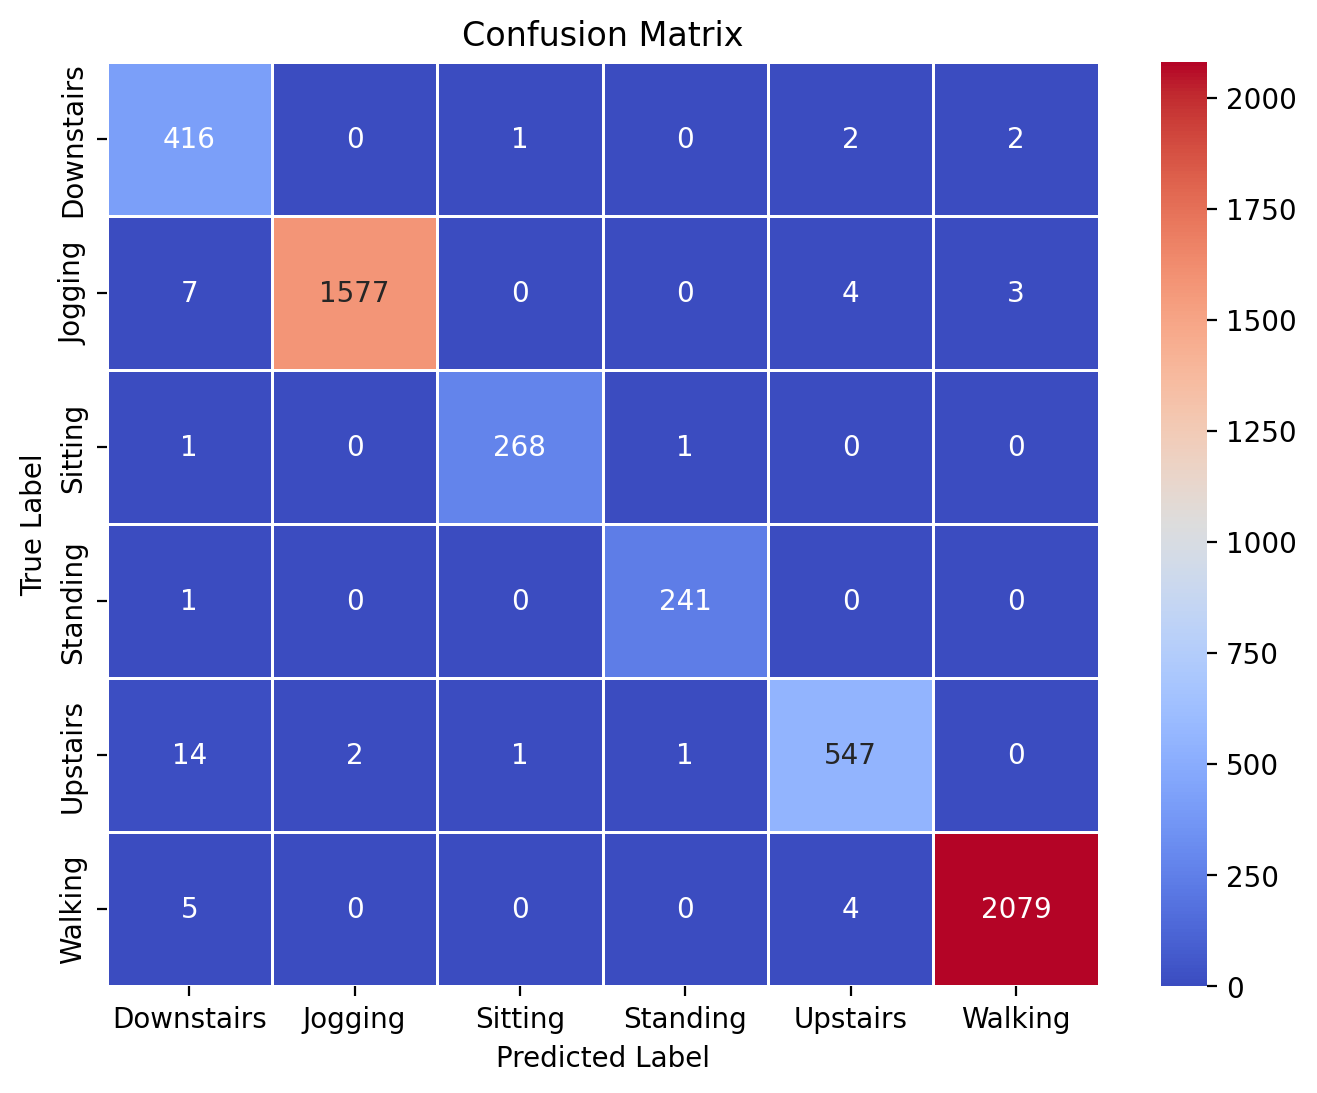

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       421
           1       1.00      0.99      0.99      1591
           2       0.99      0.99      0.99       270
           3       0.99      1.00      0.99       242
           4       0.98      0.97      0.98       565
           5       1.00      1.00      1.00      2088

    accuracy                           0.99      5177
   macro avg       0.98      0.99      0.99      5177
weighted avg       0.99      0.99      0.99      5177



In [ ]:
y_pred = model_cnn.predict(X_test)

# 원핫 인코딩을 레이블 인코딩으로 변환
max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

# 실습
- 윈도우 크기를 바꾸어본다 1, 2, 3, 초 등
- 특성을 3개 사용하지 않고 임의로 1, 2만 사용해본다
- 모델을 개선하여 성능을 높이거나, 계산량을 줄인다
- 훈련 데이터와 검증 데이터를 같은 사용자 데이터를 랜덤하게 섞어 사용한다


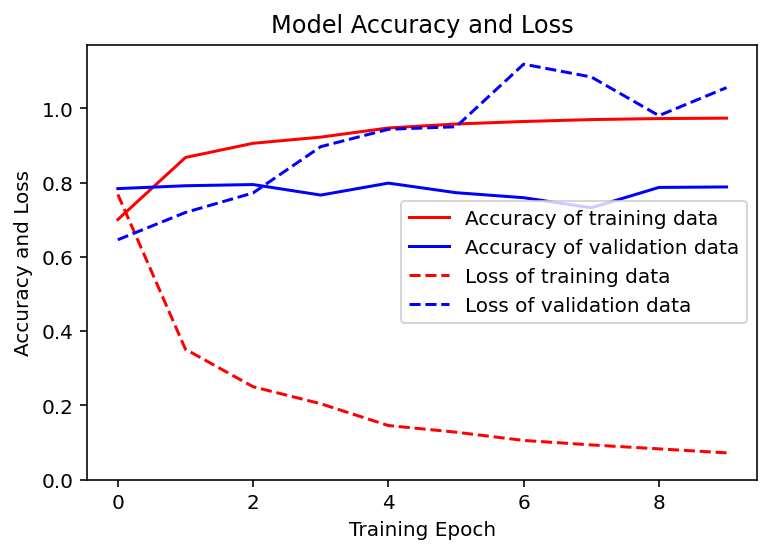

In [ ]:
show_4_graphs(history)

# RNN

In [ ]:
from keras.layers import GRU
model_rnn = Sequential()
model_rnn.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model_rnn.add(Dropout(0.2))
model_rnn.add(GRU(256))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(6, activation='softmax'))

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
model_rnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 256)          200448    
                                                                 
 dropout_32 (Dropout)        (None, 100, 256)          0         
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 596,742
Trainable params: 596,742
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_rnn.fit(X_train,
                      y_train_cat,
                      batch_size=30,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
207/207 [==============================] - 9s 18ms/step - loss: 0.8010 - accuracy: 0.7171 - val_loss: 0.4664 - val_accuracy: 0.8472
Epoch 2/30
207/207 [==============================] - 3s 15ms/step - loss: 0.3200 - accuracy: 0.8781 - val_loss: 0.7096 - val_accuracy: 0.7969
Epoch 3/30
207/207 [==============================] - 3s 16ms/step - loss: 0.2093 - accuracy: 0.9245 - val_loss: 0.5663 - val_accuracy: 0.8066
Epoch 4/30
207/207 [==============================] - 3s 15ms/step - loss: 0.1192 - accuracy: 0.9586 - val_loss: 0.8559 - val_accuracy: 0.7550


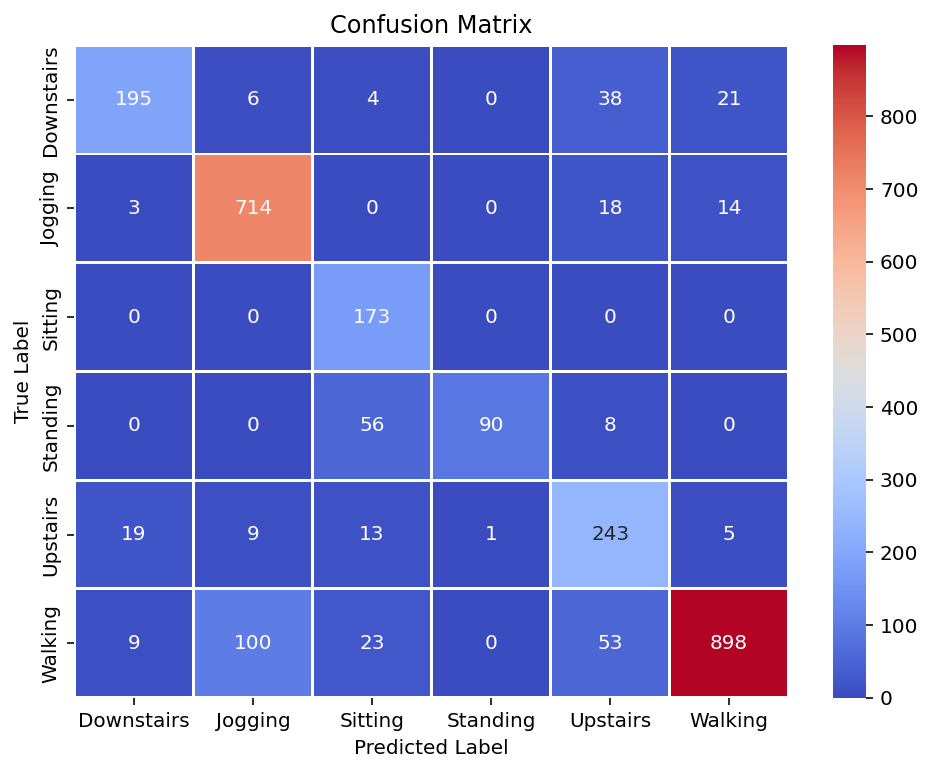

              precision    recall  f1-score   support

           0       0.86      0.74      0.80       264
           1       0.86      0.95      0.90       749
           2       0.64      1.00      0.78       173
           3       0.99      0.58      0.73       154
           4       0.68      0.84      0.75       290
           5       0.96      0.83      0.89      1083

    accuracy                           0.85      2713
   macro avg       0.83      0.82      0.81      2713
weighted avg       0.87      0.85      0.85      2713



In [ ]:
y_pred = model_rnn.predict(X_test)

# 원핫 인코딩을 레이블 인코딩으로 변환
max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

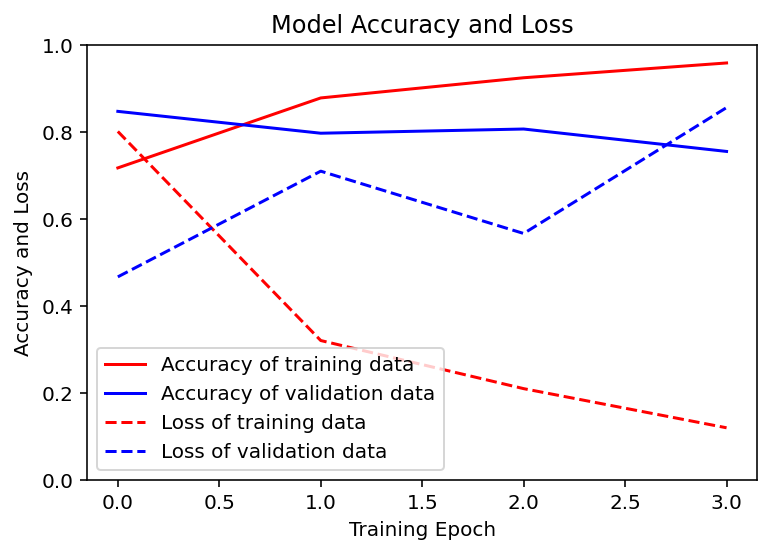

In [ ]:
show_4_graphs(history)